#Libraries

In [1]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.1-py2.py3-none-any.whl size=311285397 sha256=d4a750411bbd6aa1a6704dbefddaa062a9648325962e8432cb148162c9a88343
  Stored in directory: /root/.cache/pip/wheels/0d/77/a3/ff2f74cc9ab41f8f594dabf0579c2a7c6de920d584206e0834
Successfully built pyspark


In [2]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import seaborn as sns

#for plotting data
import matplotlib.pyplot as plt

#for linear algebra
import numpy as np

# accessing directory structure

import os
import pandas as pd


import pickle

from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext
from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.sql.functions import udf, col, isnull, when, count, stddev, mean

from pyspark.ml.regression import LinearRegression
from pyspark.mllib.evaluation import RegressionMetrics

from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, CrossValidatorModel
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.evaluation import RegressionEvaluator

# Data Pre-Processing

In [3]:
#creating spark session
spark = SparkSession \
    .builder \
    .appName('Housing Data') \
    .getOrCreate()

In [4]:
spark

In [5]:
#reading the csv file
df = (spark.read
      .format("csv")
      .option('header', 'true')
      .load("/content/housingData.csv"))


In [6]:
df.printSchema()
#original data types of columns are string, which are needed to be converted to float

root
 |-- Longitude: string (nullable = true)
 |-- Latitude: string (nullable = true)
 |-- Housing Median Age: string (nullable = true)
 |-- Total Rooms: string (nullable = true)
 |-- Total Bedrooms: string (nullable = true)
 |-- Population: string (nullable = true)
 |-- Households: string (nullable = true)
 |-- Median Income: string (nullable = true)
 |-- Median House Value: string (nullable = true)



In [7]:
columnList = [x[0] for x in df.dtypes] #creating a list with all column names
# print(columnList)

#changing datatype to float
for var in columnList:
  df = df.withColumn(var, df[var].cast('float'))

In [8]:
#show new datatype of columns
pd.DataFrame(df.dtypes, columns = ['Column Name', 'Data Type'])

,Column Name,Data Type
0,Longitude,float
1,Latitude,float
2,Housing Median Age,float
3,Total Rooms,float
4,Total Bedrooms,float
5,Population,float
6,Households,float
7,Median Income,float
8,Median House Value,float


In [9]:
df.head(5)

[Row(Longitude=-122.2300033569336, Latitude=37.880001068115234, Housing Median Age=41.0, Total Rooms=880.0, Total Bedrooms=129.0, Population=322.0, Households=126.0, Median Income=8.325200080871582, Median House Value=452600.0),
 Row(Longitude=-122.22000122070312, Latitude=37.86000061035156, Housing Median Age=21.0, Total Rooms=7099.0, Total Bedrooms=1106.0, Population=2401.0, Households=1138.0, Median Income=8.301400184631348, Median House Value=358500.0),
 Row(Longitude=-122.23999786376953, Latitude=37.849998474121094, Housing Median Age=52.0, Total Rooms=1467.0, Total Bedrooms=190.0, Population=496.0, Households=177.0, Median Income=7.257400035858154, Median House Value=352100.0),
 Row(Longitude=-122.25, Latitude=37.849998474121094, Housing Median Age=52.0, Total Rooms=1274.0, Total Bedrooms=235.0, Population=558.0, Households=219.0, Median Income=5.643099784851074, Median House Value=341300.0),
 Row(Longitude=-122.25, Latitude=37.849998474121094, Housing Median Age=52.0, Total Room

In [10]:
df.count()

20640

In [11]:
#checking null values
df.select([count(when(isnull(c),c)).alias(c) for c in df.columns]).show()

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+
|Longitude|Latitude|Housing Median Age|Total Rooms|Total Bedrooms|Population|Households|Median Income|Median House Value|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+
|        0|       0|                 0|          0|             0|         0|         0|            0|                 0|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+



There are no missing values in our current dataset

In [12]:
numericFeatures = df.toPandas().select_dtypes(include=[np.number])
categoricalFeatures = df.toPandas().select_dtypes(exclude=[np.number])
print("Number of Numerical Features : {}".format(numericFeatures.shape[1]))
print("Number of Categorical Features : {}".format(categoricalFeatures.shape[1]))

Number of Numerical Features : 9
Number of Categorical Features : 0


There are no Categorical Features in our current dataset, only Numeric Features

In [13]:
#check number amd percentage of unique values

for column in df.columns:
  print(column, format(df.select(column).distinct().count(), 'd'),
        '%.2f'%(df.select(column).distinct().count()/df.select(column).count()*100))

Longitude 844 4.09
Latitude 862 4.18
Housing Median Age 52 0.25
Total Rooms 5926 28.71
Total Bedrooms 1928 9.34
Population 3888 18.84
Households 1815 8.79
Median Income 12928 62.64
Median House Value 3842 18.61


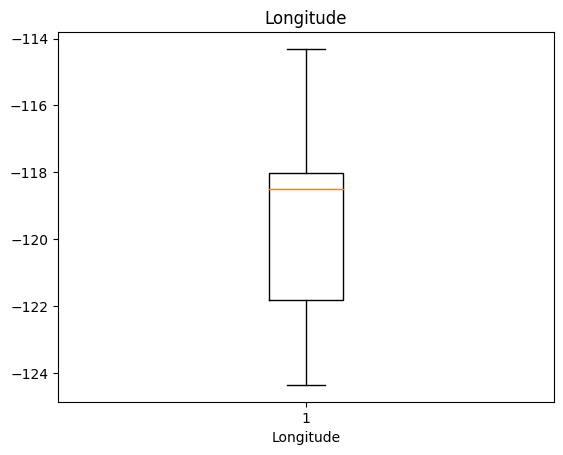

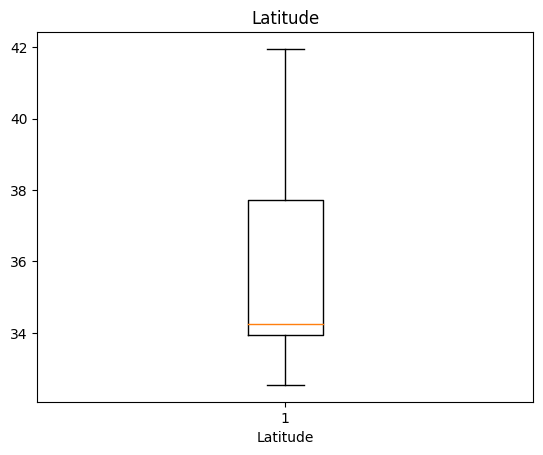

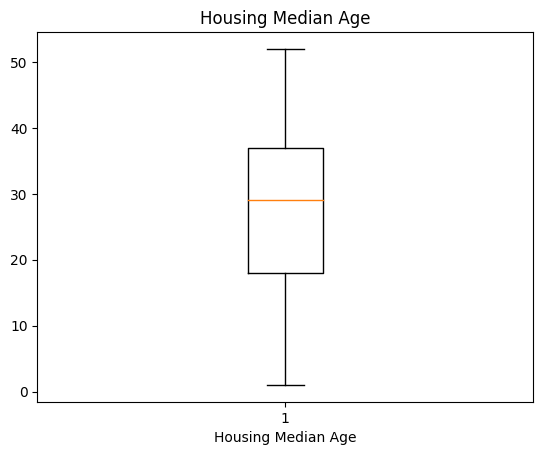

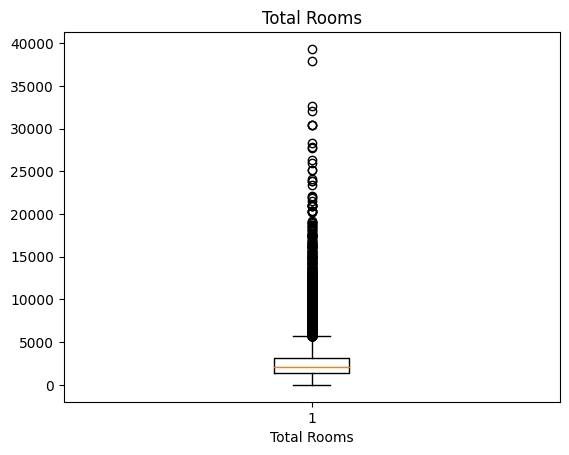

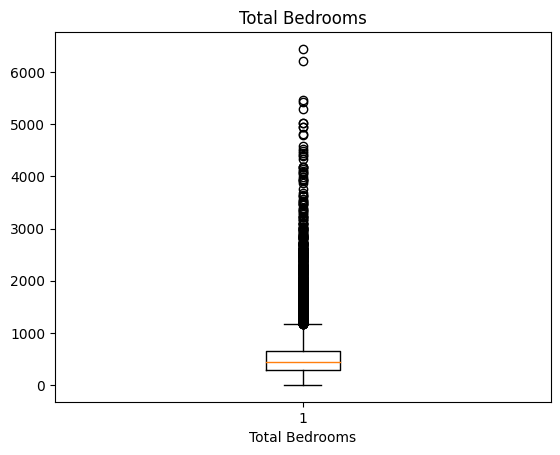

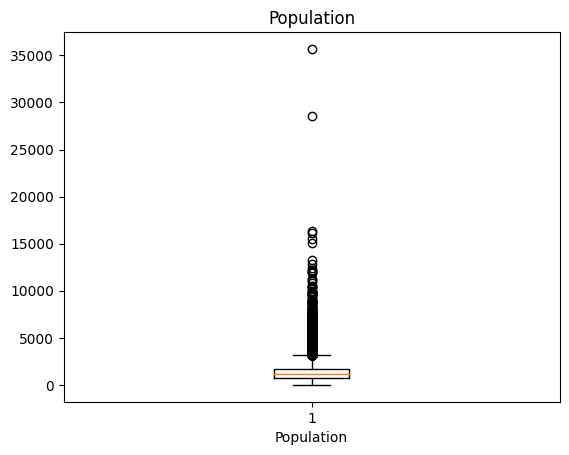

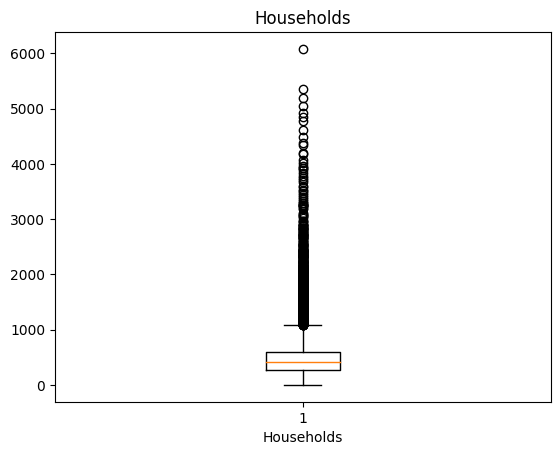

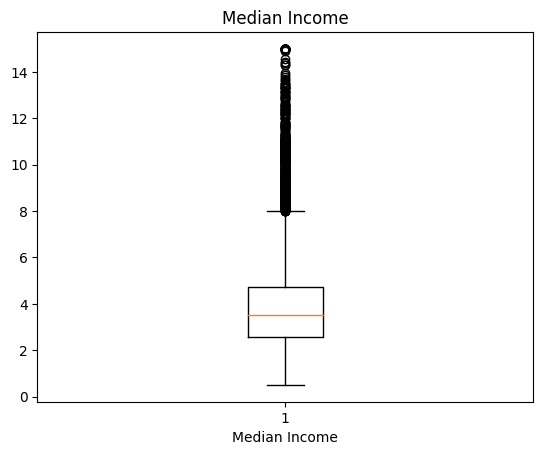

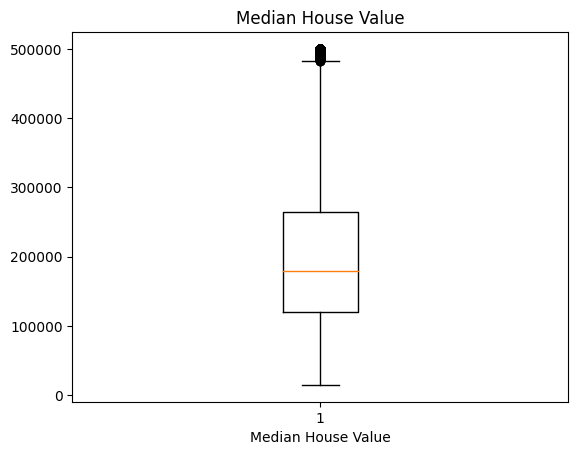

In [14]:
df_pd = df.toPandas()

for column in df_pd.columns:
    if column == "Median House Value":
        break
    ax = plt.boxplot(data=df_pd, x = column)
    plt.title(column)
    plt.xlabel(column)
    plt.show()
plt.boxplot(data=df_pd, x = "Median House Value")
plt.xlabel("Median House Value")
plt.title("Median House Value")
plt.show()

In [15]:
def calcBounds(df):
  bounds = {
      c: dict(
          zip(["q1","q3"], df.approxQuantile(c, [0.25, 0.75],0))
      )
      for c in df.columns
  }

  for x in bounds:
    iqr = bounds[x]['q3'] - bounds[x]['q1']
    bounds[x]['min'] = bounds[x]['q1'] - (iqr*1.5)
    bounds[x]['max'] = bounds[x]['q3'] + (iqr*1.5)

  return bounds
bounds = calcBounds(df)


df2=df.select("*", *[
    when(
        col(c)>bounds[c]['max'],
        1
    ).otherwise(when(
        col(c)<bounds[c]['min'],
        -1
    ).otherwise(0)
    ).alias(c+"_out")
    for c in df.columns
])

In [16]:
df2.show(10)

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+-------------+------------+----------------------+---------------+------------------+--------------+--------------+-----------------+----------------------+
|Longitude|Latitude|Housing Median Age|Total Rooms|Total Bedrooms|Population|Households|Median Income|Median House Value|Longitude_out|Latitude_out|Housing Median Age_out|Total Rooms_out|Total Bedrooms_out|Population_out|Households_out|Median Income_out|Median House Value_out|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+-------------+------------+----------------------+---------------+------------------+--------------+--------------+-----------------+----------------------+
|  -122.23|   37.88|              41.0|      880.0|         129.0|     322.0|     126.0|       8.3252|          452600.0|            0|           0|                  

In [17]:
for c in df.columns:
  # median_value = df2.approxQuantile(c, [0.5], 0.01)[0]
  # Replace values where "median_value_out" is 1 with the median value
  if(c=="Median House Value"):
    break
  df2 = df2.withColumn( c, when(col(c+"_out") == 1, bounds[c]['max']).otherwise(when(col(c+'_out')==-1, bounds[c]['min']).otherwise(col(c)) ))
  # Show the updated DataFrame
df2.show()

+-------------------+------------------+------------------+-----------+--------------+----------+----------+------------------+------------------+-------------+------------+----------------------+---------------+------------------+--------------+--------------+-----------------+----------------------+
|          Longitude|          Latitude|Housing Median Age|Total Rooms|Total Bedrooms|Population|Households|     Median Income|Median House Value|Longitude_out|Latitude_out|Housing Median Age_out|Total Rooms_out|Total Bedrooms_out|Population_out|Households_out|Median Income_out|Median House Value_out|
+-------------------+------------------+------------------+-----------+--------------+----------+----------+------------------+------------------+-------------+------------+----------------------+---------------+------------------+--------------+--------------+-----------------+----------------------+
| -122.2300033569336|37.880001068115234|              41.0|      880.0|         129.0|     

In [18]:
c = "Median House Value"
df2 = df2.withColumn( c, when(col(c+"_out") != 0, np.nan).otherwise((col(c))) )

In [19]:
df2.select([count(when(col(c+"_out")==1,c)).alias(c) for c in df.columns]).show()

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+
|Longitude|Latitude|Housing Median Age|Total Rooms|Total Bedrooms|Population|Households|Median Income|Median House Value|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+
|        0|       0|                 0|       1286|          1282|      1196|      1220|          680|              1071|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+



In [20]:
df2.select([count(when(isnull(c),c)).alias(c) for c in df.columns]).show()

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+
|Longitude|Latitude|Housing Median Age|Total Rooms|Total Bedrooms|Population|Households|Median Income|Median House Value|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+
|        0|       0|                 0|          0|             0|         0|         0|            0|                 0|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+



In [21]:
df2.columns

['Longitude',
 'Latitude',
 'Housing Median Age',
 'Total Rooms',
 'Total Bedrooms',
 'Population',
 'Households',
 'Median Income',
 'Median House Value',
 'Longitude_out',
 'Latitude_out',
 'Housing Median Age_out',
 'Total Rooms_out',
 'Total Bedrooms_out',
 'Population_out',
 'Households_out',
 'Median Income_out',
 'Median House Value_out']

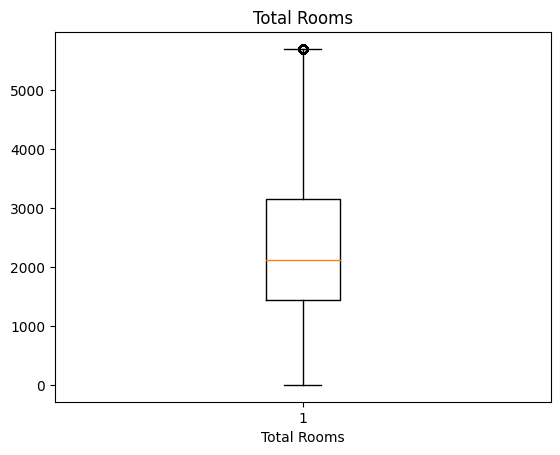

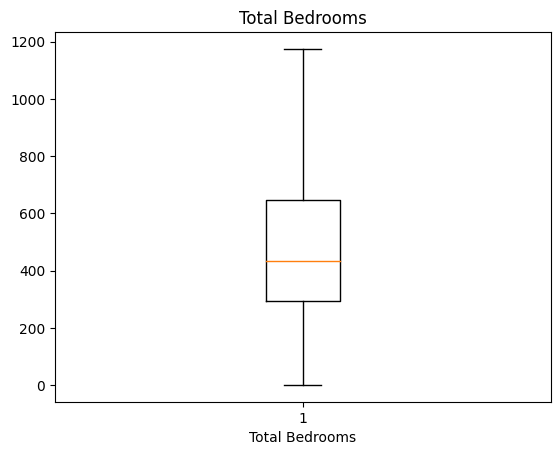

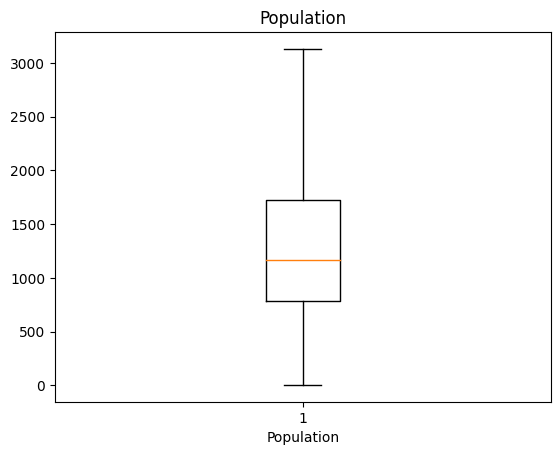

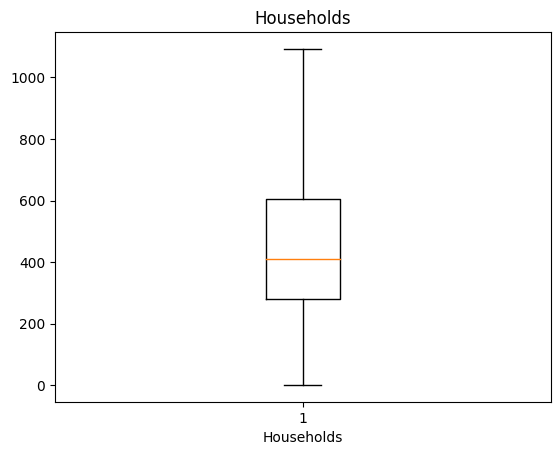

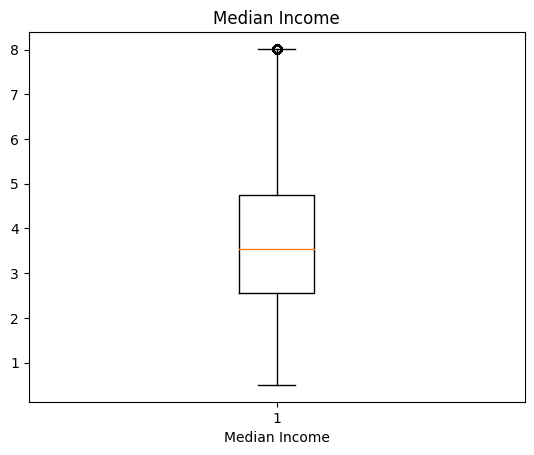

In [22]:
df_pd = df2.toPandas()

columns = ['Total Rooms','Total Bedrooms','Population','Households','Median Income']

for column in columns:
    ax = plt.boxplot(data=df_pd, x = column)
    plt.title(column)
    plt.xlabel(column)
    plt.show()


In [23]:
#assigns null value to values above upper limit
def removeUpperLimit(df,var, upperLim):
  dfReturn=df.withColumn(var, when(col(var)>=upperLim, np.nan).otherwise(col(var)) )
  return dfReturn

outColumns = ['Total Rooms', 'Median Income']
upperLimitOut = [5000, 7]

for i in range(0,2):
  df3=removeUpperLimit(df2,outColumns[i],upperLimitOut[i])

df3.show(10)

+-------------------+------------------+------------------+-----------+--------------+----------+----------+------------------+------------------+-------------+------------+----------------------+---------------+------------------+--------------+--------------+-----------------+----------------------+
|          Longitude|          Latitude|Housing Median Age|Total Rooms|Total Bedrooms|Population|Households|     Median Income|Median House Value|Longitude_out|Latitude_out|Housing Median Age_out|Total Rooms_out|Total Bedrooms_out|Population_out|Households_out|Median Income_out|Median House Value_out|
+-------------------+------------------+------------------+-----------+--------------+----------+----------+------------------+------------------+-------------+------------+----------------------+---------------+------------------+--------------+--------------+-----------------+----------------------+
| -122.2300033569336|37.880001068115234|              41.0|      880.0|         129.0|     

In [24]:
df3 = df3.withColumnRenamed('Median House Value','Price')

#Data imputation
df3 = df3.na.drop(how="any")

In [25]:
df3.select([count(when(isnull(c),c)).alias(c) for c in df3.columns]).show()

df3.count()

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+-----+-------------+------------+----------------------+---------------+------------------+--------------+--------------+-----------------+----------------------+
|Longitude|Latitude|Housing Median Age|Total Rooms|Total Bedrooms|Population|Households|Median Income|Price|Longitude_out|Latitude_out|Housing Median Age_out|Total Rooms_out|Total Bedrooms_out|Population_out|Households_out|Median Income_out|Median House Value_out|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+-----+-------------+------------+----------------------+---------------+------------------+--------------+--------------+-----------------+----------------------+
|        0|       0|                 0|          0|             0|         0|         0|            0|    0|            0|           0|                     0|              0|                 0|            

18947

#Exploratory Data Analysis

<ipython-input-26-117938d694c5>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df3.select('Price').toPandas(), color="skyblue")


+------------------+------------------+
|   skewness(Price)|   kurtosis(Price)|
+------------------+------------------+
|0.7674501217236619|0.1502790095106432|
+------------------+------------------+



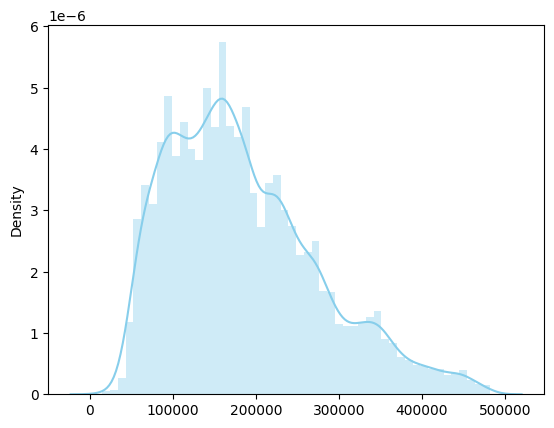

In [26]:
sns.distplot(df3.select('Price').toPandas(), color="skyblue")
df3.select(F.skewness('Price'), F.kurtosis('Price')).show()

<Axes: ylabel='Count'>

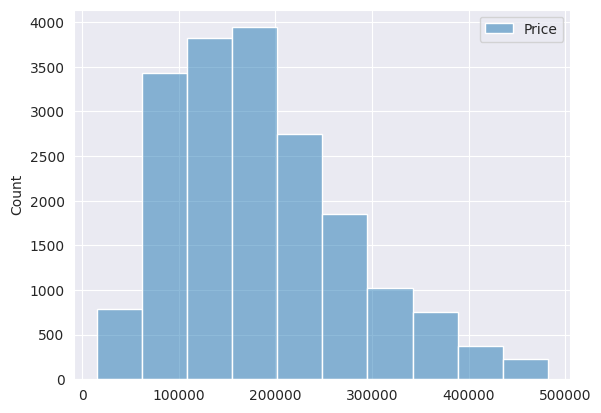

In [27]:
#Distribution of prices
sns.set_style("darkgrid")
sns.histplot(df3.select('Price').toPandas(), bins = 10)

<Axes: xlabel='Total Rooms', ylabel='avg(Price)'>

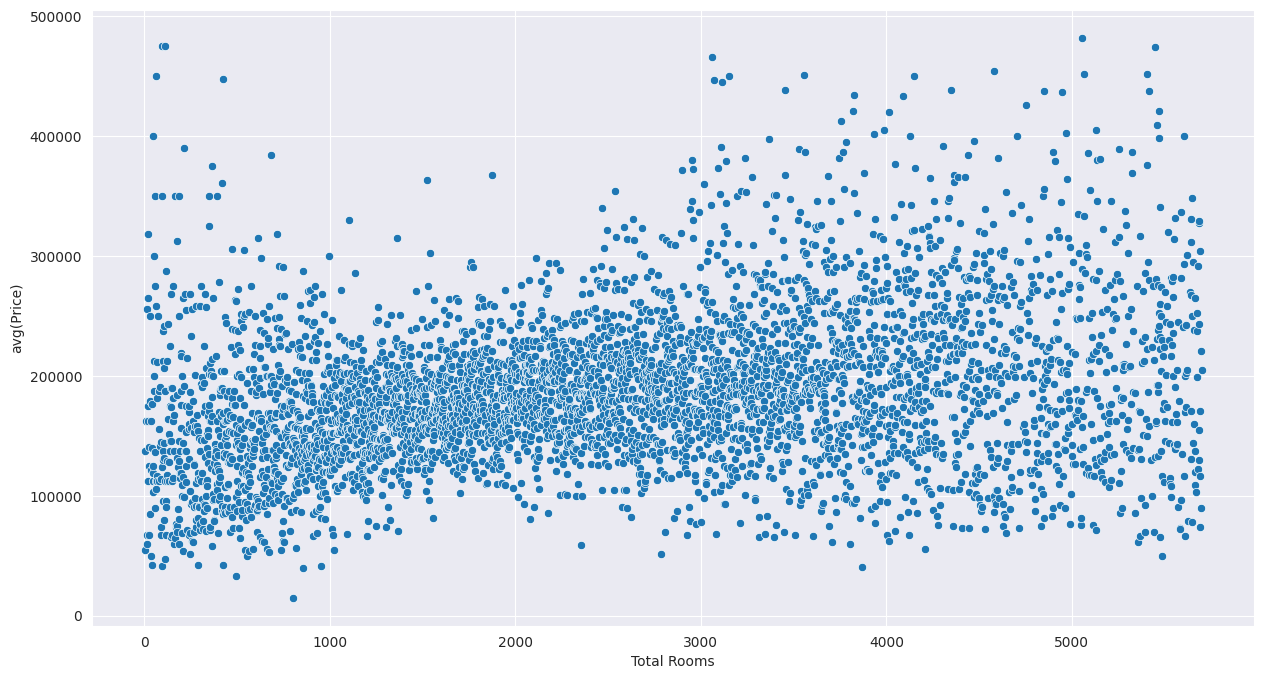

In [28]:
#Average price of house
import matplotlib.pyplot as plt
df_gb = df3.groupby('Total Rooms').avg().sort('Total Rooms').select(['Total Rooms','avg(Price)'])
df_p = df_gb.toPandas()
plt.figure(figsize = (15, 8))
sns.scatterplot(x = df_p['Total Rooms'], y = df_p['avg(Price)'] )

In [29]:
#Adding a column of per-capita income to the dataframe

df3 = df3.withColumn('per_capita_income', df3['Median Income']*10000/df3['Population'])

[(0.0, 500.0)]

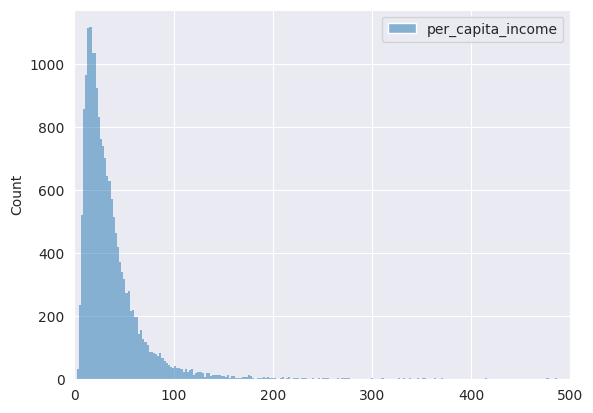

In [30]:
g = sns.histplot(df3.select('per_capita_income').toPandas())
g.set(xlim = (0, 500))

<Axes: xlabel='per_capita_income', ylabel='Price'>

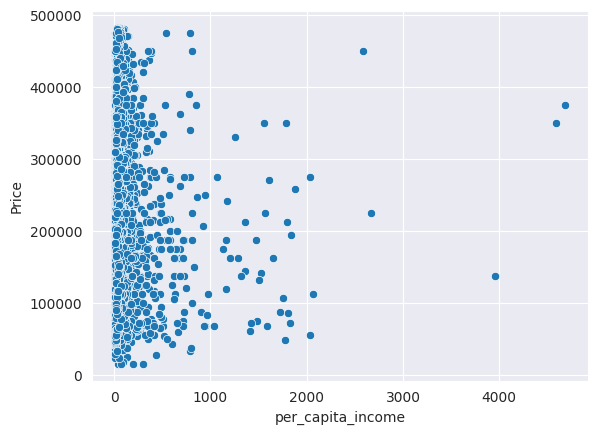

In [31]:
#Per-capita-income and prices of the home
df_p = df3.toPandas()
sns.scatterplot(x = df_p['per_capita_income'], y = df_p['Price'])

#A lot of data has near $100 per-capita income - data is skewed towards zero.

In [32]:
#Counting per capita that are less than $100
count_blocks = df3.filter('per_capita_income <  100').count()/df3.select('per_capita_income').count()*100
print("Percentage of blocks below $100 per capita: %2f" % count_blocks)

Percentage of blocks below $100 per capita: 94.832955


#Feature Extraction

In [33]:
# df3.columns
df4 = df3
df4.columns

['Longitude',
 'Latitude',
 'Housing Median Age',
 'Total Rooms',
 'Total Bedrooms',
 'Population',
 'Households',
 'Median Income',
 'Price',
 'Longitude_out',
 'Latitude_out',
 'Housing Median Age_out',
 'Total Rooms_out',
 'Total Bedrooms_out',
 'Population_out',
 'Households_out',
 'Median Income_out',
 'Median House Value_out',
 'per_capita_income']

In [34]:
cols_drop = ['Longitude_out',
 'Latitude_out',
 'Housing Median Age_out',
 'Total Rooms_out',
 'Total Bedrooms_out',
 'Population_out',
 'Households_out',
 'Median Income_out',
 'Median House Value_out']

df4 = df4.drop(*cols_drop)

In [35]:
df4.columns

['Longitude',
 'Latitude',
 'Housing Median Age',
 'Total Rooms',
 'Total Bedrooms',
 'Population',
 'Households',
 'Median Income',
 'Price',
 'per_capita_income']

<Axes: >

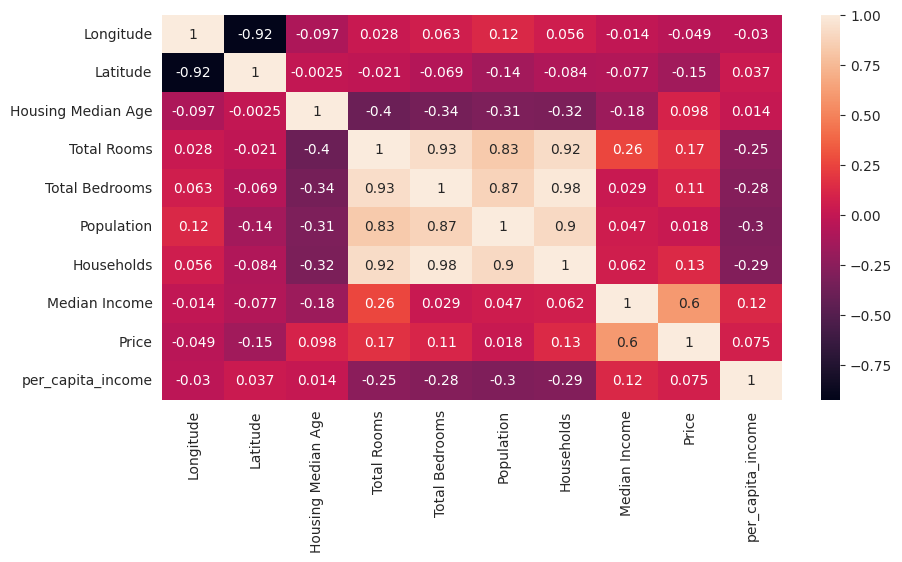

In [36]:
df_pd = df4.toPandas()
plt.figure(figsize=(10,5))
sns.heatmap(df_pd.corr(), annot=True)

#Preparing the Data for the Model

In [37]:
X = df4.drop("Price")
y = df4.select("Price")

X.columns
# y.columns

['Longitude',
 'Latitude',
 'Housing Median Age',
 'Total Rooms',
 'Total Bedrooms',
 'Population',
 'Households',
 'Median Income',
 'per_capita_income']

In [38]:
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml import Pipeline

numerical_cols = ['Longitude',
                'Latitude',
                  'Housing Median Age',
                'Total Rooms',
                'Households',
                'Median Income']

label_col = "Price"

stages = []

assembler = VectorAssembler(inputCols=numerical_cols, outputCol = "features")
stages.append(assembler)

pipeline = Pipeline(stages=stages)

inputModel = pipeline.fit(df4)
transformed_df4 = inputModel.transform(df4)


In [39]:
#standard scaler to scale the data

sc1 = StandardScaler(inputCol = "features", outputCol='sc_features',withStd=True, withMean=True)
sc_model = sc1.fit(transformed_df4)
sc_df = sc_model.transform(transformed_df4)

trainData, testData = sc_df.randomSplit([0.8,0.2],seed=1)
# trainData, testData = transformed_df4.randomSplit([0.7,0.3],seed=1)

sc_feat = sc_df.select('sc_features')


In [40]:
sc_feat.show()

+--------------------+
|         sc_features|
+--------------------+
|[-1.3403925757717...|
|[-1.3403925757717...|
|[-1.3403925757717...|
|[-1.3403925757717...|
|[-1.3403925757717...|
|[-1.3453820638934...|
|[-1.3403925757717...|
|[-1.3453820638934...|
|[-1.3453820638934...|
|[-1.3453820638934...|
|[-1.3453820638934...|
|[-1.3453820638934...|
|[-1.3453820638934...|
|[-1.3503677461509...|
|[-1.3503677461509...|
|[-1.3453820638934...|
|[-1.3503677461509...|
|[-1.3503677461509...|
|[-1.3503677461509...|
|[-1.3503677461509...|
+--------------------+
only showing top 20 rows



#Gradient Boosted Tree

In [41]:
from pyspark.ml.regression import GBTRegressor

gbt_regressor = GBTRegressor(featuresCol='sc_features', labelCol=label_col)


pipeline_gbtr = Pipeline(stages=[gbt_regressor])

model_gbtr = pipeline_gbtr.fit(trainData)
predictions_gbtr = model_gbtr.transform(testData)

predictions_gbtr.select('features', label_col, 'prediction').show()

+--------------------+--------+------------------+
|            features|   Price|        prediction|
+--------------------+--------+------------------+
|[-124.26000213623...|111400.0| 84233.19366625091|
|[-124.19000244140...| 90100.0| 134831.3628341476|
|[-124.19000244140...| 69000.0| 83985.56218501378|
|[-124.19000244140...| 70000.0| 70500.77753130416|
|[-124.18000030517...|107000.0|101276.34621465686|
|[-124.16999816894...| 70500.0| 76051.83459203804|
|[-124.16999816894...| 75500.0|  81489.9363951376|
|[-124.16999816894...|105900.0| 86620.87579695285|
|[-124.16000366210...| 92700.0| 90792.82112594877|
|[-124.16000366210...| 74700.0| 88049.56385483546|
|[-124.15000152587...|100600.0|120413.20818612601|
|[-124.15000152587...| 86400.0|108002.59003808477|
|[-124.15000152587...|103100.0| 87272.36535561098|
|[-124.13999938964...|100500.0|114538.39447834766|
|[-124.12999725341...| 86900.0| 77244.29456754422|
|[-124.12999725341...| 83000.0|108855.36006305277|
|[-124.09999847412...| 55000.0|

In [42]:
#evaluation
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

rmse_evaluator_gbtr = RegressionEvaluator(labelCol=label_col, predictionCol='prediction', metricName='rmse')
rmse = rmse_evaluator_gbtr.evaluate(predictions_gbtr)

mae_evaluator_gbtr = RegressionEvaluator(labelCol=label_col, predictionCol='prediction', metricName='mae')
mae = mae_evaluator_gbtr.evaluate(predictions_gbtr)


print(f"Root Mean Squared Error (RMSE) on test data: {rmse}")
print(f"Mean Squared Error (MSE) on test data: {rmse**2}")
print(f"Mean Absolute Error (MAE) on test data: {mae}")

Root Mean Squared Error (RMSE) on test data: 52063.23646203964
Mean Squared Error (MSE) on test data: 2710580590.902254
Mean Absolute Error (MAE) on test data: 37522.08019608401


#Random Forest Regressor

In [ ]:
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator

rfr = RandomForestRegressor(featuresCol='sc_features',
                            labelCol=label_col,
                            seed=42,
                            numTrees=2000)

pipeline_rfr = Pipeline(stages=[rfr])

model_rfr = pipeline_rfr.fit(trainData)
rfr_prediction = model_rfr.transform(testData)

rfr_prediction.select('features', label_col, 'prediction').show()

In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator

evaluator_rfr = RegressionEvaluator(labelCol=label_col, predictionCol='prediction', metricName='rmse')
rmse = evaluator_rfr.evaluate(rfr_prediction)
print(f"Root Mean Squared Error (RMSE) on test data: {rmse}")
print(f"Mean Squared Error (MSE) on test data: {rmse**2}")

#Linear Regression

In [ ]:
from pyspark.ml.regression import LinearRegression

linear_reg = LinearRegression(featuresCol='sc_features', labelCol=label_col)

pipeline_lr = Pipeline(stages=[linear_reg])

model_lr = pipeline_lr.fit(trainData)
predictions_lr = model_lr.transform(testData)

predictions_lr.select('features', label_col, 'prediction').show()

In [ ]:
#evaluation

evaluator_lr = RegressionEvaluator(labelCol=label_col, predictionCol='prediction', metricName='rmse')
rmse = evaluator_lr.evaluate(predictions_lr)
print(f"Root Mean Squared Error (RMSE) on test data: {rmse}")
print(f"Mean Squared Error (MSE) on test data: {rmse**2}")

#Saving the models

In [ ]:
#GBT
model_gbtr.save('gbtr_model')

#RFR
model_rfr.save('rfr_model')

#LR|
model_lr.save('lr_model')



In [ ]:
# !zip -r /content/gbtr_model.zip /content/gbtr_model

#Flask host


In [ ]:
!pip install pyngrok

In [ ]:
import flask
from flask import Flask, render_template, request
from pyspark.ml import PipelineModel
from pyspark.sql import Row
from pyngrok import ngrok

In [ ]:
 # Running the flask app
app = Flask(__name__)

#load model
loaded_model_gbtr = PipelineModel.load(r'/content/gbtr_model')


@app.route('/', methods=['GET'])
def home():
    return render_template(r'index.html')

@app.route('/', methods=['POST'])
def predict():
    int_feature = [float(x) for x in request.form.values()]
    featureDict = dict(zip(numerical_cols, int_feature))


    row_df = Row(**featureDict)
    single_df = spark.createDataFrame([row_df])

    assembler = VectorAssembler(inputCols=numerical_cols, outputCol = "sc_features")
    pipeline = Pipeline(stages=[assembler])

    inputModel = pipeline.fit(single_df)
    transformed_single_df = inputModel.transform(single_df)



    prediction_single_row = loaded_model_gbtr.transform(transformed_single_df)

    predicted_value = prediction_single_row.select('prediction').collect()[0]['prediction']


    return render_template('index.html', prediction_text='The Housing price is {}'.format(predicted_value))

if __name__ == '__main__':
    app.run()
    # Run ngrok to expose the app
    public_url = ngrok.connect(port=5000)
    print(" * Running on", public_url)

 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit


PyngrokNgrokHTTPError: ignored